<a href="https://colab.research.google.com/github/alecbidaran/Pytorch_excersies/blob/main/Simase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_snippets
!wget https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
!unzip face-detection.zip


     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 212 kB 22.7 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 10.1 MB 43.0 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
--2021-10-19 08:24:31--  https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ua1rr8btkmpqjxh/face-detection.zip [following]
--2021-10-19 08:24:32--  https://www.dropbox.com/s/raw/ua1rr8btkmpqjxh/face-detection.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce5b44b3f5789452a13f1c920f5.dl.dropboxusercontent.com/cd/0/inline/

NameError: ignored

In [ ]:
import torch 
import numpy as np 
import cv2 
import torch_snippets,torchsummary
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import glob 
from torch_snippets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import matplotlib.pyplot as plt


In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, folder, transform=None, should_invert=True):
        self.folder = folder
        self.items = Glob(f'{self.folder}/*/*') 
        self.transform = transform
    def __getitem__(self, ix):
        itemA = self.items[ix]
        person = fname(parent(itemA))
        same_person = randint(2)
        if same_person:
            itemB = choose(Glob(f'{self.folder}/{person}/*', silent=True))
        else:
            while True:
                itemB = choose(self.items)
                if person != fname(parent(itemB)):
                    break
        imgA = read(itemA)
        imgB = read(itemB)
        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)
        return imgA, imgB, np.array([1-same_person])
    def __len__(self):
        return len(self.items)

In [ ]:
trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, (0.01,0.2),
                            scale=(0.9,1.1)),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trn_ds = SiameseNetworkDataset(folder="./data/faces/training/", transform=trn_tfms)
val_ds = SiameseNetworkDataset(folder="./data/faces/testing/", transform=val_tfms)

trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=64)

2021-10-19 08:34:02.355 | INFO     | torch_snippets.paths:inner:24 - 370 files found at ./data/faces/training//*/*
2021-10-19 08:34:02.362 | INFO     | torch_snippets.paths:inner:24 - 30 files found at ./data/faces/testing//*/*


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0]')

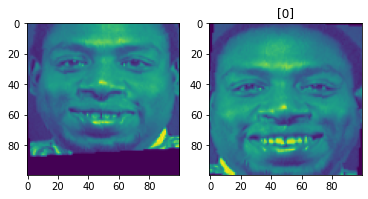

In [ ]:
imga,imgb,label=trn_ds[10]
plt.subplot(1,2,1)
plt.imshow(imga.squeeze(0))
plt.subplot(1,2,2)
plt.imshow(imgb.squeeze(0)) 
plt.title(label)

In [ ]:
def conv_block(ni,no):
  return torch.nn.Sequential(
      torch.nn.Dropout(0.2),
      torch.nn.Conv2d(ni,no,kernel_size=3,padding="same",padding_mode='reflect'),
      torch.nn.ReLU(inplace=True),
      torch.nn.BatchNorm2d(no),
      torch.nn.MaxPool2d(kernel_size=3,stride=2)

  )

In [ ]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.features=torch.nn.Sequential(
        conv_block(1,16),
        conv_block(16,32),
        conv_block(32,32),
        torch.nn.Flatten(),
        torch.nn.Linear(3872,500),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(500,10)
    )
  def forward(self,input1,input2):
    output1=self.features(input1)
    output2=self.features(input2)
    return output1,output2

In [ ]:
model=SiameseNetwork().to(device)

In [ ]:
torchsummary.summary(model,[(1,100,100),(1,100,100)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1          [-1, 1, 100, 100]               0
            Conv2d-2         [-1, 16, 100, 100]             160
              ReLU-3         [-1, 16, 100, 100]               0
       BatchNorm2d-4         [-1, 16, 100, 100]              32
         MaxPool2d-5           [-1, 16, 49, 49]               0
           Dropout-6           [-1, 16, 49, 49]               0
            Conv2d-7           [-1, 32, 49, 49]           4,640
              ReLU-8           [-1, 32, 49, 49]               0
       BatchNorm2d-9           [-1, 32, 49, 49]              64
        MaxPool2d-10           [-1, 32, 24, 24]               0
          Dropout-11           [-1, 32, 24, 24]               0
           Conv2d-12           [-1, 32, 24, 24]           9,248
             ReLU-13           [-1, 32, 24, 24]               0
      BatchNorm2d-14           [-1, 32,

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self,output1,output2,label):
      eculidean_distance=torch.nn.functional.pairwise_distance(output1,output2,keepdim=True)
      loss_conservative=torch.mean((1-label) * torch.pow(eculidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - eculidean_distance, min=0.0), 2))
      acc=((eculidean_distance>0.6)==label).float().mean()
      return loss_conservative,acc

In [ ]:

model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
def train_batch(model,data,criterion,optimizer):
  imgsA, imgsB, labels = [t.to(device) for t in data]
  optimizer.zero_grad()
  output1,output2=model(imgsA,imgsB)
  loss,acc=criterion(output1,output2,labels)
  loss.backward()
  optimizer.step()
  return loss.item(),acc.item()
@torch.no_grad()
def valid_batch(model,data,criterion):
  model.eval()
  imgsA, imgsB, labels = [t.to(device) for t in data]
  output1,output2=model(imgsA,imgsB)
  loss,acc=criterion(output1,output2,labels)
  return loss.item(),acc.item()

In [ ]:
n_epochs = 200
log = Report(n_epochs)
for epoch in range(n_epochs):
  N = len(trn_dl)
  for i,train_data in enumerate(trn_dl):
    train_loss,acc_loss=train_batch(model,train_data,criterion,optimizer)
    log.record(epoch+(1+i)/N,trn_loss=train_loss,trn_acc=acc_loss,end='\r')
  N = len(val_dl)
  for i,test_data in enumerate(val_dl):
    train_loss,acc_loss=valid_batch(model,test_data,criterion)
    log.record(epoch+(1+i)/N,val_loss=train_loss,val_acc=acc_loss,end='\r')
  if epoch%20==0: log.report_avgs(epoch+1)
  if epoch==10: optimizer=torch.optim.Adam(model.parameters(),lr =0.00001)




EPOCH: 1.000	trn_loss: 4.875	trn_acc: 0.475	val_loss: nan	val_acc: nan	(1.31s - 260.91s remaining)
EPOCH: 1.167	trn_loss: 1.814	trn_acc: 0.453	(1.50s - 256.37s remaining)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


EPOCH: 21.000	trn_loss: 0.607	trn_acc: 0.714	val_loss: 0.341	val_acc: 0.800	(26.49s - 225.81s remaining)
EPOCH: 41.000	trn_loss: 0.606	trn_acc: 0.732	val_loss: 0.515	val_acc: 0.733	(51.54s - 199.87s remaining)
EPOCH: 61.000	trn_loss: 0.533	trn_acc: 0.751	val_loss: 0.377	val_acc: 0.867	(76.75s - 174.88s remaining)
EPOCH: 81.000	trn_loss: 0.518	trn_acc: 0.728	val_loss: 0.258	val_acc: 0.933	(101.79s - 149.55s remaining)
EPOCH: 101.000	trn_loss: 0.463	trn_acc: 0.739	val_loss: 0.422	val_acc: 0.800	(126.69s - 124.18s remaining)
EPOCH: 121.000	trn_loss: 0.493	trn_acc: 0.774	val_loss: 0.270	val_acc: 0.867	(151.69s - 99.04s remaining)
EPOCH: 141.000	trn_loss: 0.454	trn_acc: 0.782	val_loss: 0.484	val_acc: 0.700	(176.69s - 73.93s remaining)
EPOCH: 161.000	trn_loss: 0.447	trn_acc: 0.757	val_loss: 0.409	val_acc: 0.867	(201.64s - 48.84s remaining)
EPOCH: 181.000	trn_loss: 0.426	trn_acc: 0.750	val_loss: 0.171	val_acc: 0.933	(226.51s - 23.78s remaining)
EPOCH: 200.000	val_loss: 0.471	val_acc: 0.833	(2

100%|██████████| 301/301 [00:00<00:00, 3231.75it/s]
2021-10-18 16:03:31.139 | INFO     | torch_snippets.torch_loader:plot_epochs:135 - metric val_loss was not fully recorded. Plotting final epochs using last recorded value


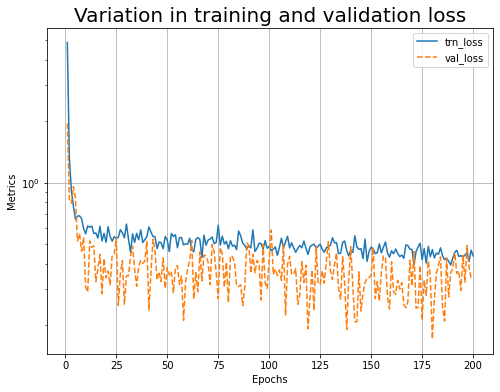

100%|██████████| 301/301 [00:00<00:00, 2583.34it/s]
2021-10-18 16:03:31.896 | INFO     | torch_snippets.torch_loader:plot_epochs:135 - metric val_acc was not fully recorded. Plotting final epochs using last recorded value


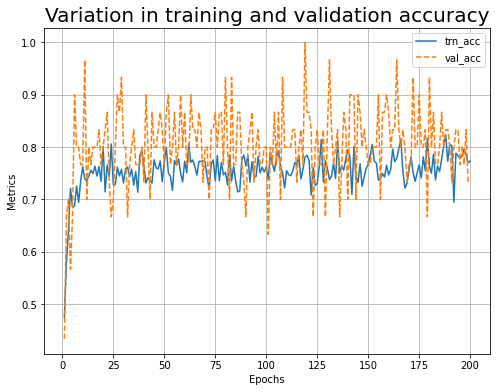

In [ ]:
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title='Variation in training and validation loss')
log.plot_epochs(['trn_acc', 'val_acc'], title='Variation in training and validation accuracy')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


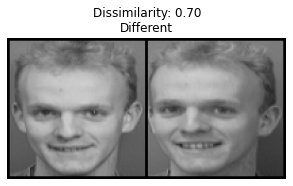

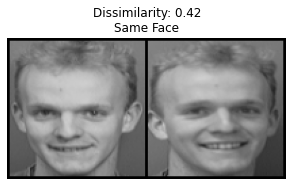

In [ ]:
model.eval()
val_dl = DataLoader(val_ds,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(val_dl)
x0, _, _ = next(dataiter)

for i in range(2):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5),0)
    output1,output2 = model(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    output = 'Same Face' if euclidean_distance.item() < 0.6 else 'Different'
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()